# Generative Adverserial Networks in PyTorch

Deep neural networks은 주로 분류(classification)나 회귀(regression)와 같은 지도학습에 사용됩니다.
하지만, GANs(Generative Adverserial Networks)은 신경망 생성 모델로써 매우 다른 목적으로 사용됩니다.

> 생성 적 모델링은 입력 데이터의 규칙이나 패턴을 자동으로 발견하고 학습하는 머신 러닝의 비지도 학습 작업으로, 모델을 사용하여 원래 데이터 세트에서 그럴듯하게 가져올 수있는 새로운 예제를 생성하거나 출력 할 수 있습니다. - [더보기](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

Generative Modeling에 사용되는 접근 방식이 많지만 본 수업에서의 Generative Adversarial Network는 다음 접근 방식을 사용해 보도록 하겠습니다.

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

*Generator*와 *Discriminator*가 있습니다. Generator는 임의의 vector/matrix를 생성하면 "가짜(fake)" 샘플을 생성하고, Discriminator는 이를 "진짜(real)"(학습에 의한 데이터)인지 "가짜(fake)"(Generator에 의한 데이터)인지 분류(Classification)합니다.

Generator와 Discriminator는 동시에 학습되는데, 몇 epoch동안 Discriminator를 먼저 학습시키고 나서 Generator를 학습하는 과정을 반복합니다. 이렇게하면 생성자와 판별자가 작업을 더 잘 수행할 수 있습니다.

결과는 다음과 같습니다.
 ([소스](https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/)), 모든 예제는 GAN을 이용했습니다:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-Photorealistic-Human-Faces-Generated-by-a-GAN.png" alt="gans_results" width="480">


GAN은, 학습이 매우 불안정(unstable)하며, 하이퍼 파라미터에 민감하고, 활성화 함수 및 정규화에 매우 민감합니다. 본 예제에서는, MNIST 데이터셋의 이미지와 유사한 손으로 쓴 숫자의 이미지를 생성하도록 GAN을 훈련해보도록 하겠습니다.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >

본 코드는 다음 소스를 참고하였습니다: [Reference](https://github.com/yunjey/pytorch-tutorial). 

## 차례
* 문제 정의
* 데이터로드 (변환 및 정규화, transforms and normalization)
    * Denormalize for visual inspection of samples
* Discriminator 모델 정의
    * 활성화 함수 정의: Leaky ReLU
* Generator 모델 정의
    * 활성화 함수 정의: TanH
    * 출력 샘플 보기
* 학습을 위한 손실함수, optimizers와 유용한 함수 정의
    * For discriminator
    * For generator
* 모델 학습
    * 중간 생성 이미지 파일 저장
* 일부 출력 보기
* 모델 저장

## Load the Data

먼저 'torchvision.datasets'에서 'MNIST' helper class를 사용하여 데이터를 PyTorch 데이터 세트로 다운로드하고 가져옵니다.

In [3]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to data\MNIST\raw\train-images-idx3-ubyte.gz
9920512it [04:45, 32418.24it/s]                             Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to data\MNIST\raw\train-labels-idx1-ubyte.gz

  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:26, 62748.80it/s]

  1%|▏         | 24576/1648877 [00:00<00:36, 45060.44it/s]

  2%|▏         | 32768/1648877 [00:01<00:41, 38796.33it/s]

  2%|▏         | 40960/1648877 [00:01<00:43, 36752.36it/s]

  3%|▎         | 49152/1648877 [00:01<00:45, 34935.13it/s]

  3%|▎         | 57344/1648877 [00:02<00:47, 33539.19it/s]

  4%|▍         | 65536/1648877 [00:02<00:47, 33573.64it/s]

픽셀 값을 (0, 1) 범위에서 (-1, 1) 범위로 변환하고 있습니다. 이렇게하는 이유는 Generator 모델을 정의할 때 명확해집니다. 데이터에서 샘플 텐서를 살펴 보겠습니다.

In [4]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

9920512it [05:38, 29304.43it/s]
32768it [00:52, 619.31it/s]              
1654784it [00:52, 31595.37it/s]
8192it [00:00, 11305.22it/s]            Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])



(tensor(-1.), tensor(1.))

예상대로, 픽셀의 범위가 -1에서 1까지입니다. 이미지를 비정규화하고 볼수있는 도우미 함수를 정의하도록 하겠습니다. 이러한 함수는 추후 생성된 Generator에서 이미지를 볼때 유용하게 사용됩니다.

In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


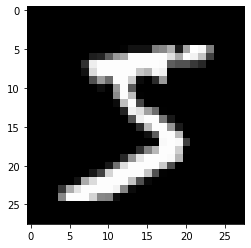

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

마지막으로 이미지를 일괄 적으로로드하는 데이터 로더를 만들어 보겠습니다.

In [7]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 1, 9, 3, 6, 8, 9, 3, 0, 4, 9, 0, 3, 2, 9, 0, 4, 5, 3, 2, 8, 2, 1, 5,
        5, 4, 9, 0, 4, 7, 5, 8, 6, 0, 8, 5, 2, 9, 8, 2, 3, 1, 1, 3, 8, 2, 3, 1,
        5, 8, 0, 7, 2, 7, 8, 2, 9, 5, 2, 1, 2, 2, 8, 0, 2, 4, 1, 4, 9, 4, 1, 8,
        4, 6, 3, 0, 6, 3, 1, 1, 3, 4, 3, 1, 9, 8, 3, 1, 3, 5, 8, 5, 7, 9, 1, 2,
        6, 8, 4, 5])


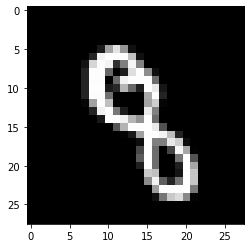

In [8]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

사용 가능한 경우 데이터와 모델을 GPU로 이동하는데 사용할 수 있는 'device'도 생성합니다.

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

## Discriminator 모델

Discriminator는 이미지를 입력으로 받아 "real"또는 "generated"으로 분류하려고합니다. 이런 의미에서 다른 신경망혹은 Encoder와 같습니다(앞에 수업내용 참고!!!). 판별기에 CNN을 사용할 수 있지만 단순히 MLP(Multi Layer Perceptron)을 이용하여 구성하고자 합니다. 각 28x28 이미지를 784 크기의 벡터로 취급합니다.

In [11]:
image_size = 784
hidden_size = 256

In [12]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

Discriminator에 대해 Leaky ReLU 활성화 함수(activate function)를 사용합니다.


<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  일반 ReLU 함수와 달리 Leaky ReLU는 음수 값에 대해 작은 기울기 신호를 전달할 수 있습니다. 결과적으로 Discriminator의 기울기가 Generator로 더 강하게 흐릅니다. 역전파(back-prop) 시 0의 기울기를 전달하는 대신 작은 음(negative)의 기울기를 전달합니다.  - [Source](https://sthalles.github.io/advanced_gans/)


다른 이진 분류(binary classification) 모델과 마찬가지로 Discriminator의 출력은 0과 1 사이의 단일 숫자이며 입력 이미지가 가짜(fake) 즉 생성될 가능성으로 해석(분류) 될 수 있습니다.

분류 모델을 선택한 장치로 이동해 보겠습니다.

In [13]:
D.to(device);

## Generator 모델

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. 
Generator에 대한 입력은 일반적으로 이미지 생성을 위한 시드로 사용되는 임의의 백터 또는 행렬 입니다. 다시 한 번, 간단하게 유지하기 위해 3 개의 레이어가있는 피드 포워드 신경망을 사용하고 출력은 28x28 픽셀 이미지로 변환 할 수있는 784 크기의 벡터가됩니다.

In [14]:
latent_size = 64

In [15]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

Generator의 레이어의 출력에 TanH 활성화 함수를 사용하였습니다.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation  is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


TanH 활성화의 출력이 `[-1,1]` 범위에 있기 때문에 학습 데이터 세트의 이미지에 동일한 변환을 적용했습니다. Generator에서  출력 벡터를 생성하고 출력을 변환 및 비정규 화하여 이미지로 보겠습니다.

In [16]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

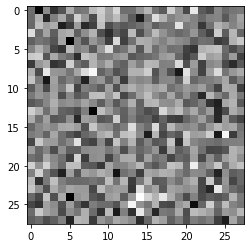

In [17]:
plt.imshow(gen_imgs[0], cmap='gray');

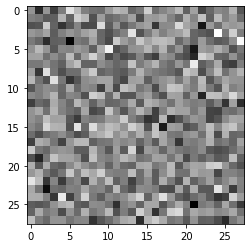

In [18]:
plt.imshow(gen_imgs[1], cmap='gray');


예상 할 수 있듯이 Generator의 출력은 기본적으로 랜덤 노이즈입니다. Generator의 출력 배치를 파일에 저장할 수있는 도우미 함수를 정의해 보겠습니다.

Generator를 선택한 device로 이동합시다.


In [19]:
G.to(device);

## Discriminator 학습

Discriminator는 이진 분류 모델이므로 이진 교차 엔트로피 손실 함수(binary cross entropy loss function)를 사용하여 실제 이미지와 생성 된 이미지를 얼마나 잘 구별 할 수 있는지 정량화 할 수 있습니다.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [20]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

그래디언트를 재설정하고 판별자를 훈련하는 도우미 함수를 정의해 보겠습니다.

In [27]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # 로스 합침
    d_loss = d_loss_real + d_loss_fake #로스 바뀐거(-아니라 +임!) 주의! 강의자료 보기! 
    # 기울기 초기화
    reset_grad()
    # 기울기 계산
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

다음은 Discriminator를 훈련하는 단계입니다.


- 이미지가 실제 MNIST 데이터셋에서 선택되면 Discriminator가 1을 출력하고 0이면 생성된 것이라고 예상한다.

- 먼저 실제 이미지 배치를 전달하고, loss를 계산한 다음에, 1로 설정한다.

- 그 다음, Generator를 사용하여 가짜 이미지 배치를 생성하고 Discriminator에 전달하고 Loss를 계산하여 대상 레이블을 0으로 설정한다.

- 마지막으로 두 손실을 더하고 전체 손실을 경사하강법을 사용하여 Discriminator에 weights를 조정한다.

Discriminator를 훈련하는 동안에 Generator의 가중치를 변경하지 않는다는 것을 유의하는것이 중요함!!!!

(`d_optimizer` 오직 `D.parameters()`에만 영향을 미침!)

## Generator 학습

Generator의 출력은 이미지이기 때문에 Generator를 훈련할 수 있는 방법이 명확하지 않습니다.
여기에서 Discriminator를 Loss Function의 일부로 사용하는 방법을 사용합니다. 작동 방식은 다음과 같습니다.


- Generator를 사용하여 이미지 배치를 생성하고 Discriminator에 전달합니다.

- 목표 라벨을 "1(진짜, real)"로 설정하여 loss를 계산합니다. Generator의 목적은 Discriminator를 속이는 것이 목적입니다.

- Loss를 사용하여 경사하강법을 수행합니다. 즉, Generator의 가중치를 변경하므로 실제와 같은 이미지를 생성하는데 더 유용합니다.

다음은 실제 코드 구현입니다.

In [28]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [29]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## 모델 학습

모델의 진행 상황을 시각적으로 검사하기 위해 생성기의 중간 출력을 저장할 수있는 디렉토리를 생성하겠습니다.

In [30]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

생성된 이미지를 보면서 시각적 비교에 사용할 수있는 실제 이미지 배치를 저장해 보겠습니다.

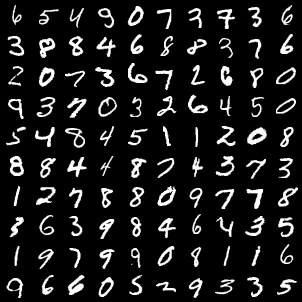

In [31]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

또한 모든 epoch이 끝날 때 생성된 이미지의 배치를 디스크에 저장하는 도우미 함수를 만들어 보겠습니다.
Generator에 고정된 특정 seed의 입력 벡터를 사용하여 모델을 학습 할 때 생성 된 개별 이미지가 시간이 지남에 따라 어떻게 진화하는지 확인합니다.

Saving fake_images-0000.png


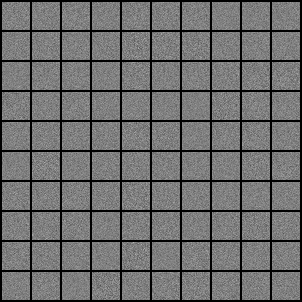

In [32]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

이제 모델을 훈련 할 준비가되었습니다. 각 epoch마다 Discriminator를 먼저 훈련시킨 다음 Generator를 훈련시킵니다. GPU를 사용하지 않는 경우 훈련에 시간이 걸릴 수 있습니다.

In [33]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0353, g_loss: 4.2484, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1568, g_loss: 5.8056, D(x): 0.97, D(G(z)): 0.10
Epoch [0/300], Step [600/600], d_loss: 0.0701, g_loss: 4.9228, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0151, g_loss: 5.9558, D(x): 1.00, D(G(z)): 0.01
Epoch [1/300], Step [400/600], d_loss: 0.1478, g_loss: 3.9306, D(x): 0.99, D(G(z)): 0.11
Epoch [1/300], Step [600/600], d_loss: 0.2602, g_loss: 5.1161, D(x): 0.90, D(G(z)): 0.04
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5355, g_loss: 4.4755, D(x): 0.86, D(G(z)): 0.13
Epoch [2/300], Step [400/600], d_loss: 0.6745, g_loss: 3.0371, D(x): 0.87, D(G(z)): 0.31
Epoch [2/300], Step [600/600], d_loss: 0.3461, g_loss: 4.1143, D(x): 0.85, D(G(z)): 0.08
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.6933, g_loss: 1.4383, D(x): 0.69, D(G(z)): 0.57
Epoch [3/300], Step [400/6

KeyboardInterrupt: 

이제 모델을 학습 했으므로 체크 포인트를 저장할 수 있습니다.

In [42]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

다음은 10 번째, 50 번째, 100 번째 및 300 번째 교육 epoch 이후 생성 된 이미지의 모습입니다.

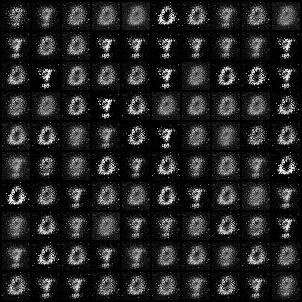

In [43]:
Image('./samples/fake_images-0010.png')

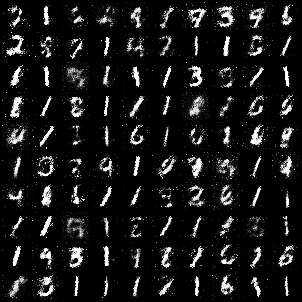

In [44]:
Image('./samples/fake_images-0050.png')

In [45]:
Image('./samples/fake_images-0100.png')

FileNotFoundError: No such file or directory: './samples/fake_images-0100.png'

In [46]:
Image('./samples/fake_images-0300.png')

FileNotFoundError: No such file or directory: './samples/fake_images-0300.png'

OpenCV를 사용하여 각 Epoch 이후 생성 된 샘플 이미지를 비디오로 결합하여 훈련 과정을 시각화 할 수 있습니다.

In [47]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

f:\2021연구\Naver MYBOX\2021연구\이선우_강의\기계학습응용\Deep_Learning_Zero_to_Gan\15) mnist-gan\gans_training.avi

시간이 지남에 따라 손실이 어떻게 변하는지 시각화 할 수도 있습니다. 손실을 시각화하는 것은 훈련 과정을 디버깅하는 데 매우 유용합니다. GAN의 경우 Discriminator의 손실이 너무 높아지지 않고 시간이 지남에 따라 Generator의 손실이 줄어들 것으로 예상합니다.

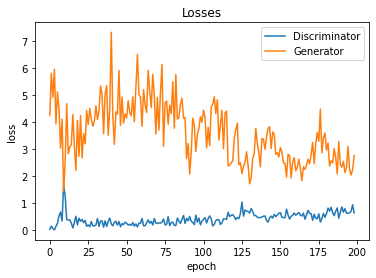

In [48]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

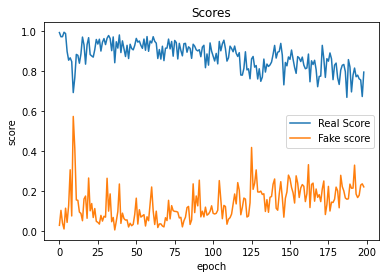

In [49]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');